In [1]:
import xgboost as xgb
import shap
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

from DataFields import DateReportedFields
from ProjectFunctions import one_hot_encode_vascular_problems, convert_date_to_binary

#### Create Dataset

In [2]:
def create_dataset(columns_to_drop = [], index = 1 ):
    df_diagnosed = pd.read_csv("diagnosed_processed.csv")
    df_undiagnosed = pd.read_csv(f"undiagnosed_csvs/undiagnosed_{index}_{index}.csv")
    
    df_merged = pd.concat([df_diagnosed, df_undiagnosed], ignore_index=True, sort=False)
    
    df_merged = one_hot_encode_vascular_problems(df_merged)
    df_merged = df_merged.drop(columns=columns_to_drop) # columns to exclude, if wanted 
    
    df_merged = convert_date_to_binary(df_merged, DateReportedFields)
    
    # split to test and train
    X = df_merged.drop('Vascular Dementia Report Date', axis=1)  # Features
    y = df_merged['Vascular Dementia Report Date']  # Target
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    return X_train, X_test, y_train, y_test
    

#### Create XGB Classifier

In [3]:
def train_dataset(X_train, X_test, y_train, y_test):
    xgb_model = xgb.XGBClassifier(eval_metric='logloss')
    xgb_model.fit(X_train, y_train)
    
    y_pred = xgb_model.predict(X_test)
    y_prob = xgb_model.predict_proba(X_test)[:, 1]
    
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

    return xgb_model, y_pred, y_prob

#### Plot ROC Curve

In [4]:
def plot_ROC(y_test, y_prob, index = 1):
    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title(f"ROC Curve for dataset_{index}")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"dataset_output/roc_curve_dataset_{index}.png")
    plt.show()

#### Plot Confusion Matrix

In [5]:
def plot_confusion(y_test, y_pred, index = 1):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for dataset_{index}')
    plt.tight_layout()
    plt.savefig(f"dataset_output/confusion_matrix_dataset_{index}.png")
    plt.show()

#### SHAP Explainer

In [6]:
def plot_explainer(xgb_model, X_train, X_test, index = 1):
    explainer = shap.Explainer(xgb_model, X_train, feature_names=X_train.columns)
    shap_values = explainer(X_test)
    
    shap.summary_plot(shap_values, X_test, show = False)
    plt.savefig(f"dataset_output/shap_summary_dataset_{index}.png", bbox_inches="tight")

### Run multiple iterations

Accuracy: 1.0
ROC AUC Score: 1.0


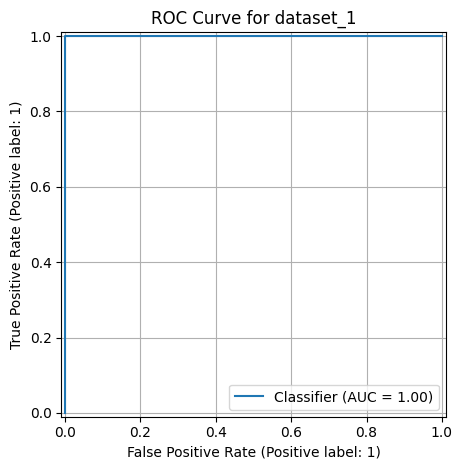

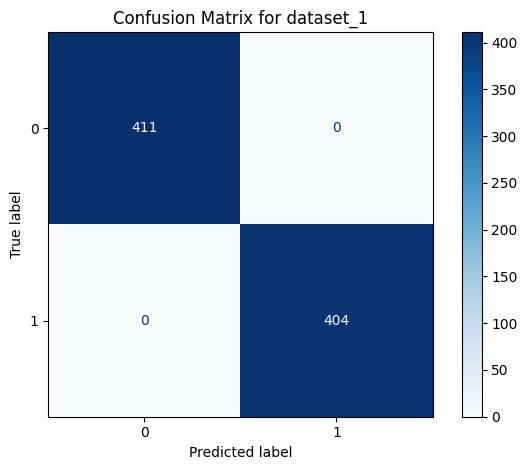

Accuracy: 0.9983633387888707
ROC AUC Score: 0.9967530568969073


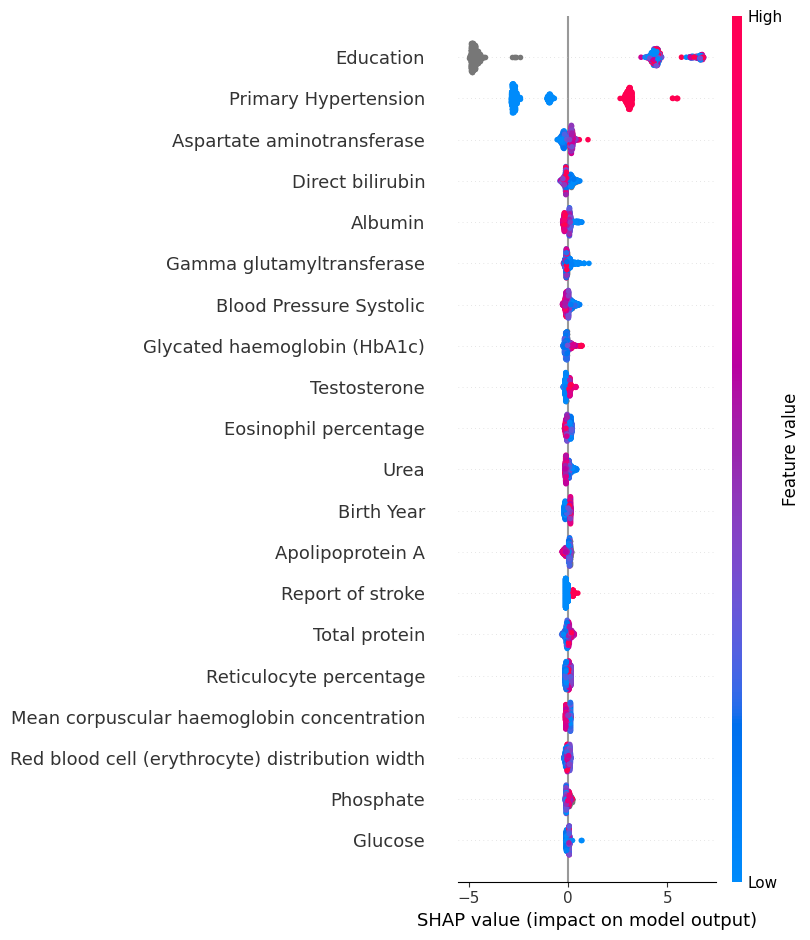

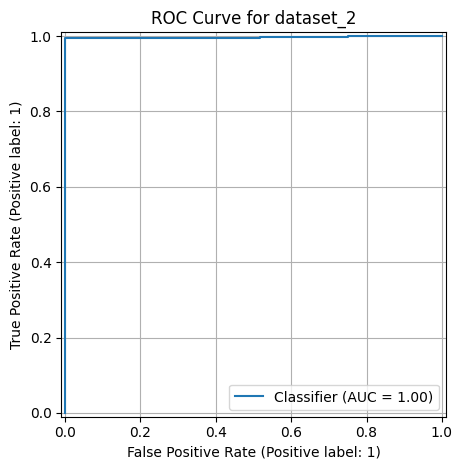

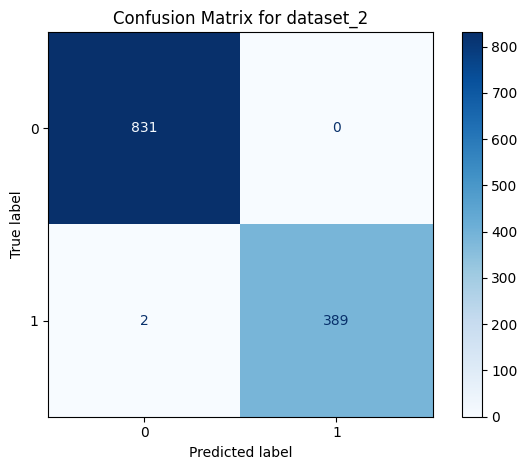

Accuracy: 0.9975445058317987
ROC AUC Score: 0.9948721052206891


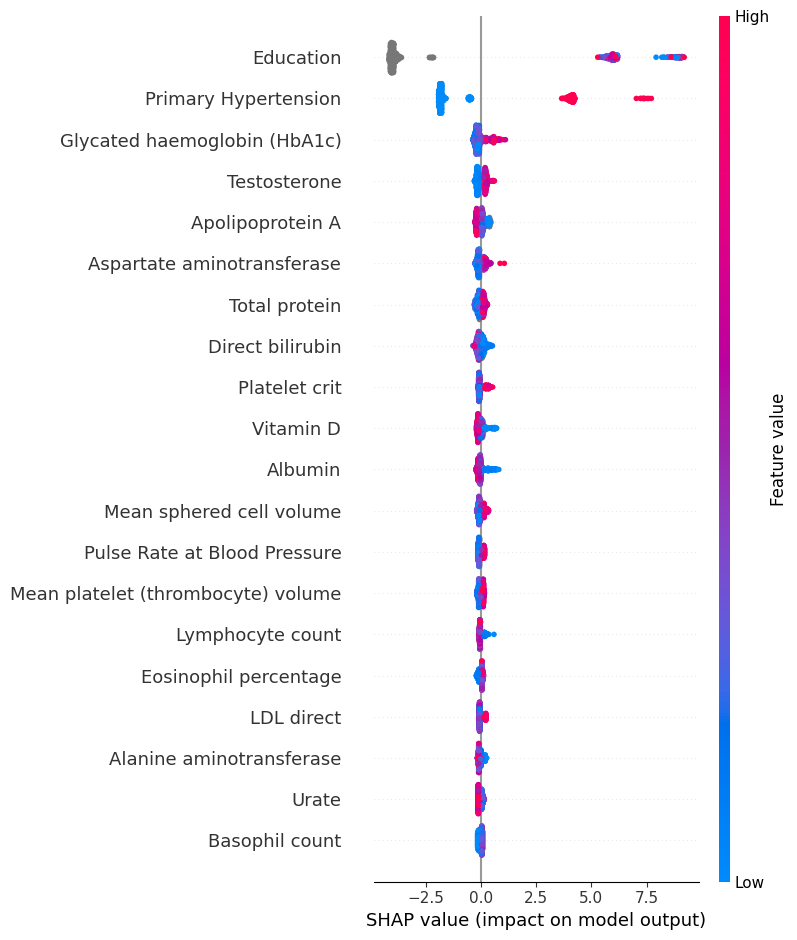

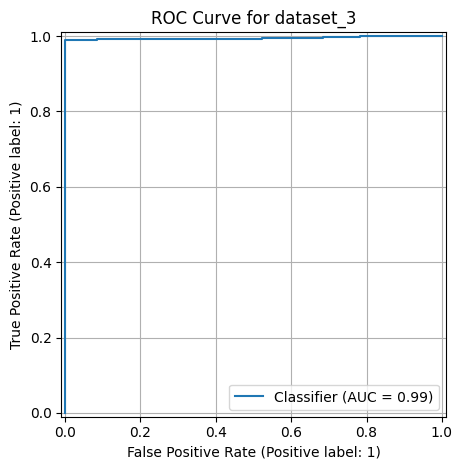

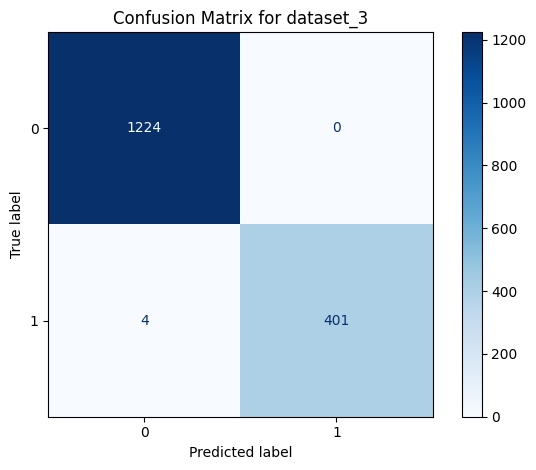

Accuracy: 0.9990176817288802
ROC AUC Score: 0.9980326174409933


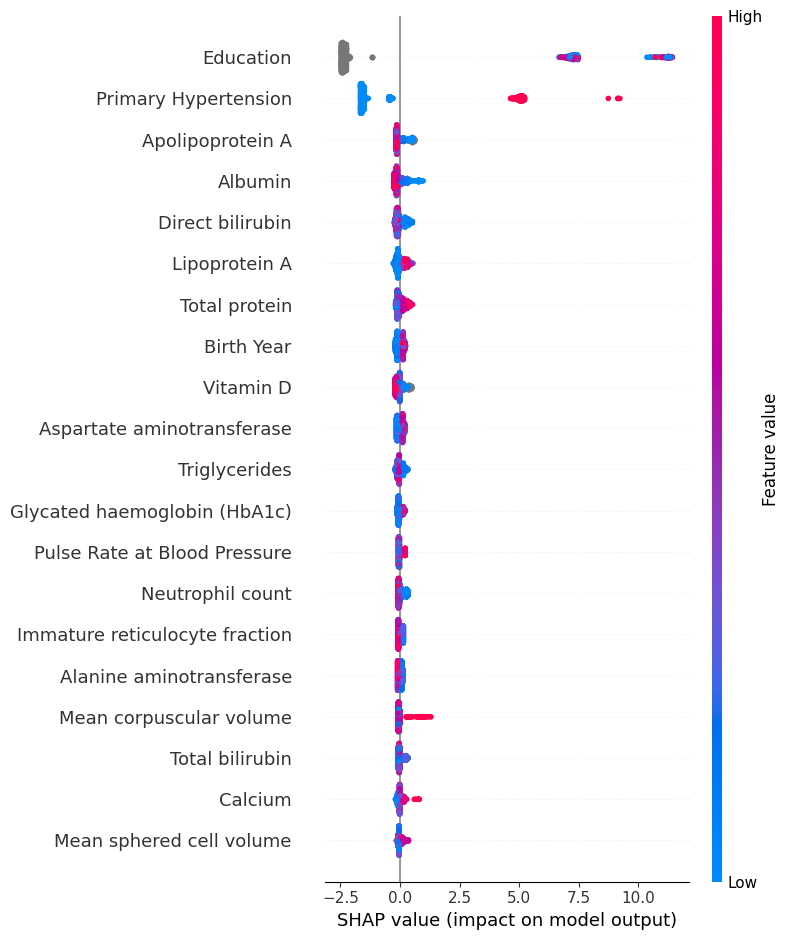

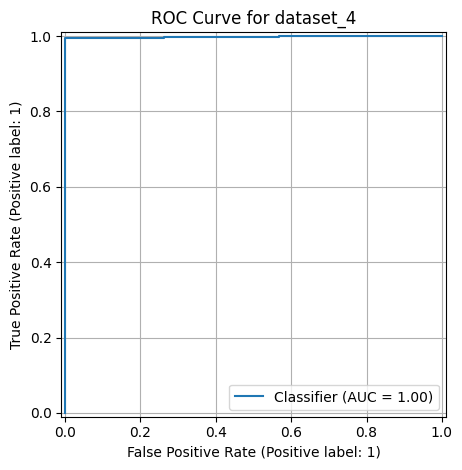

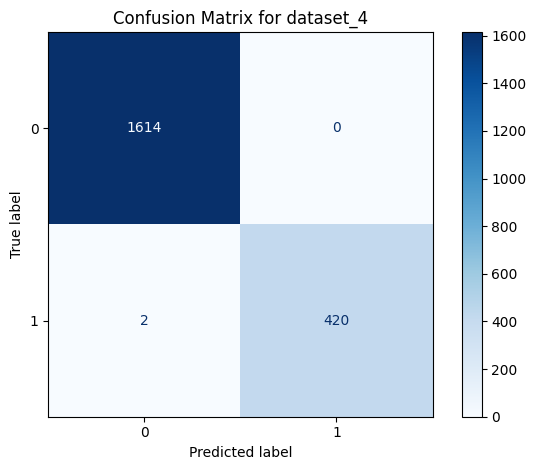

Accuracy: 0.9995908346972177
ROC AUC Score: 0.9988929032013352


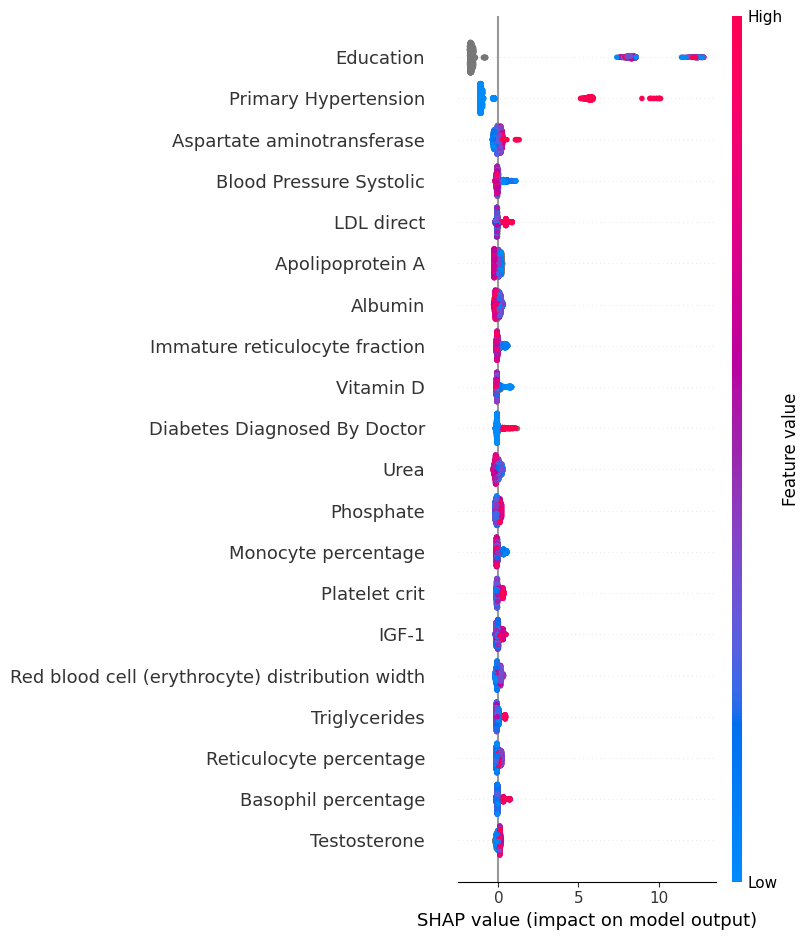

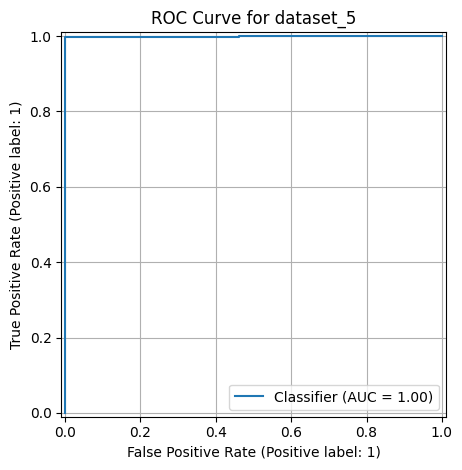

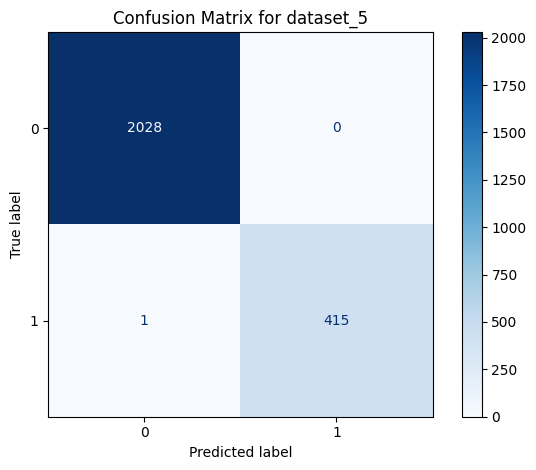

Accuracy: 1.0
ROC AUC Score: 1.0


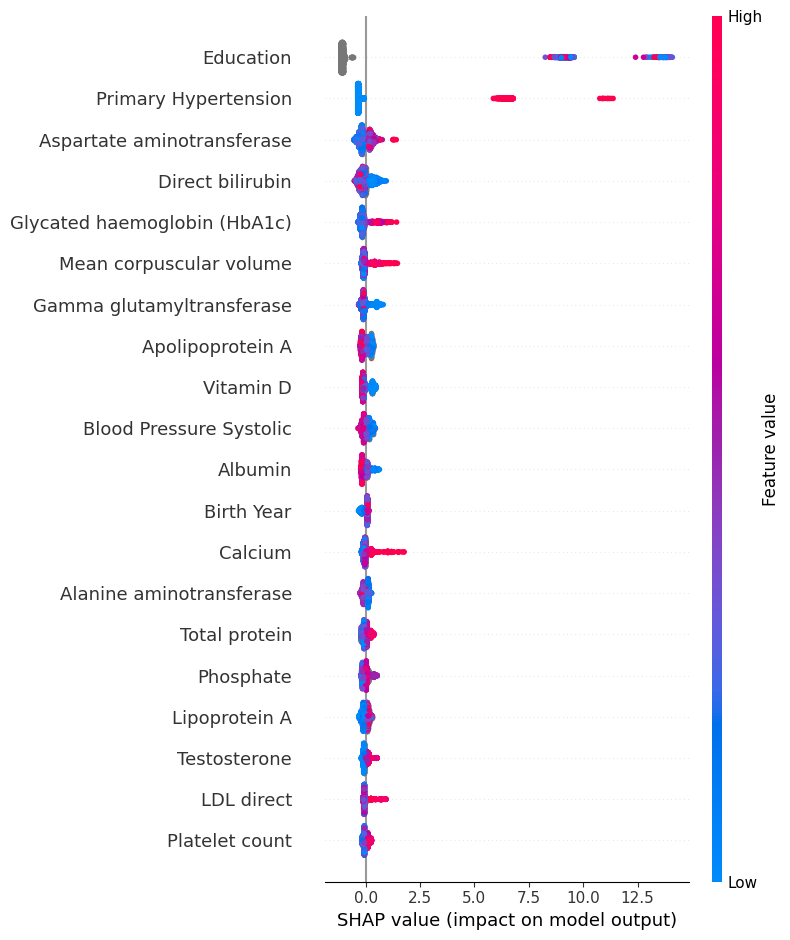

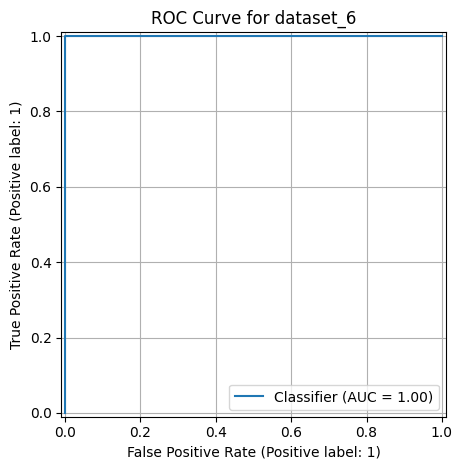

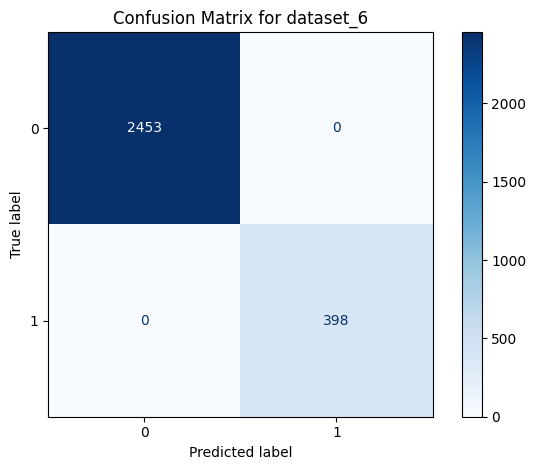

Accuracy: 0.9990791896869244
ROC AUC Score: 0.9965015910171537


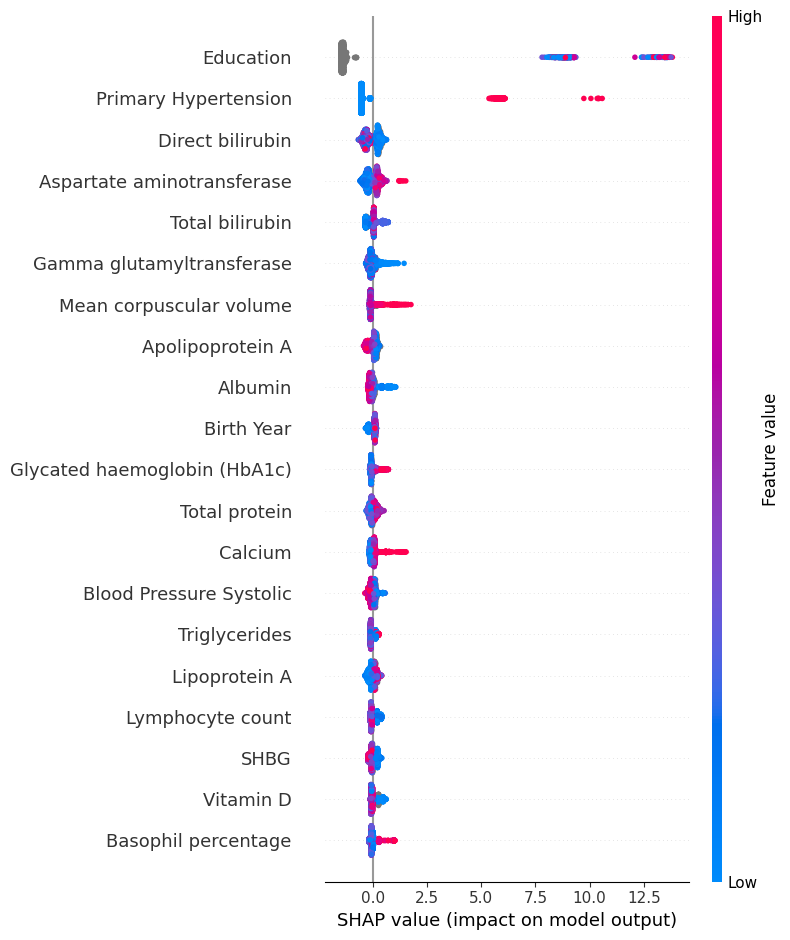

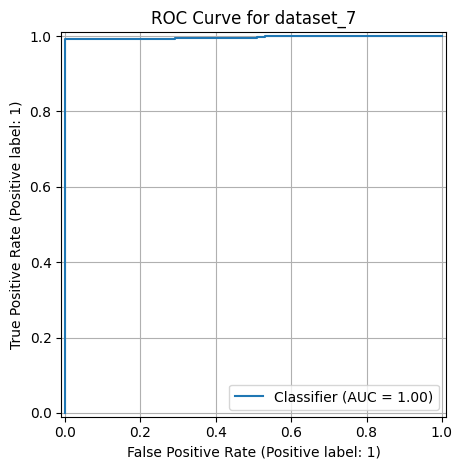

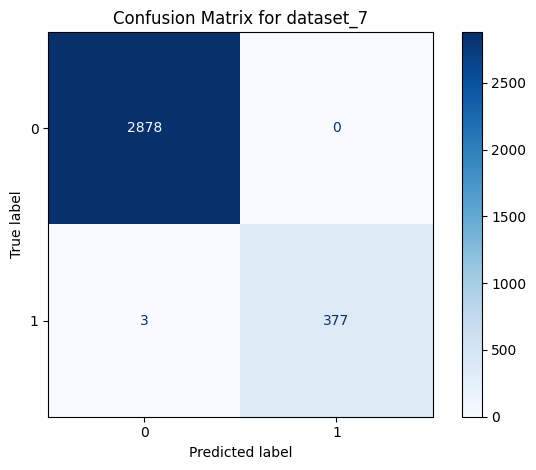

Accuracy: 0.9994425863991081
ROC AUC Score: 0.9983160875371484


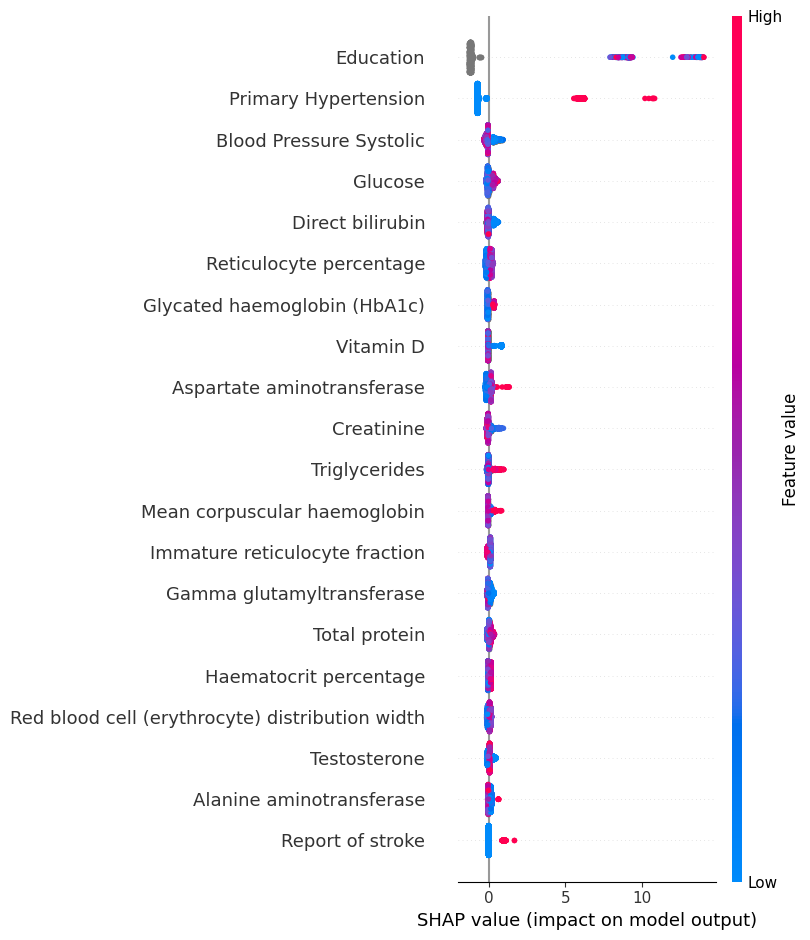

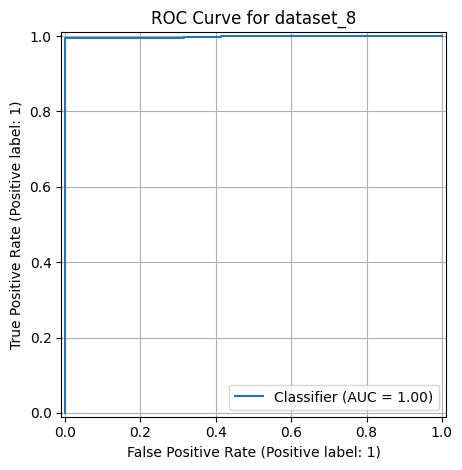

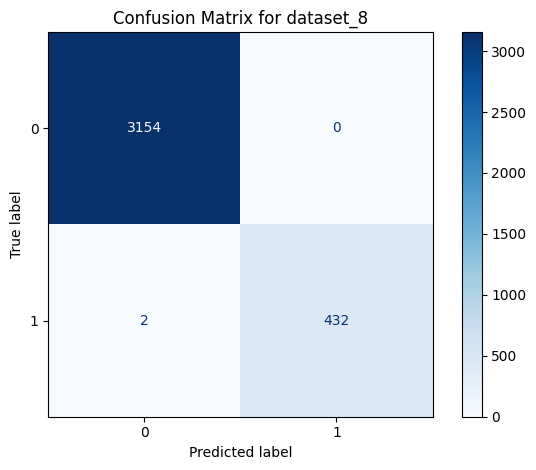

Accuracy: 1.0
ROC AUC Score: 1.0


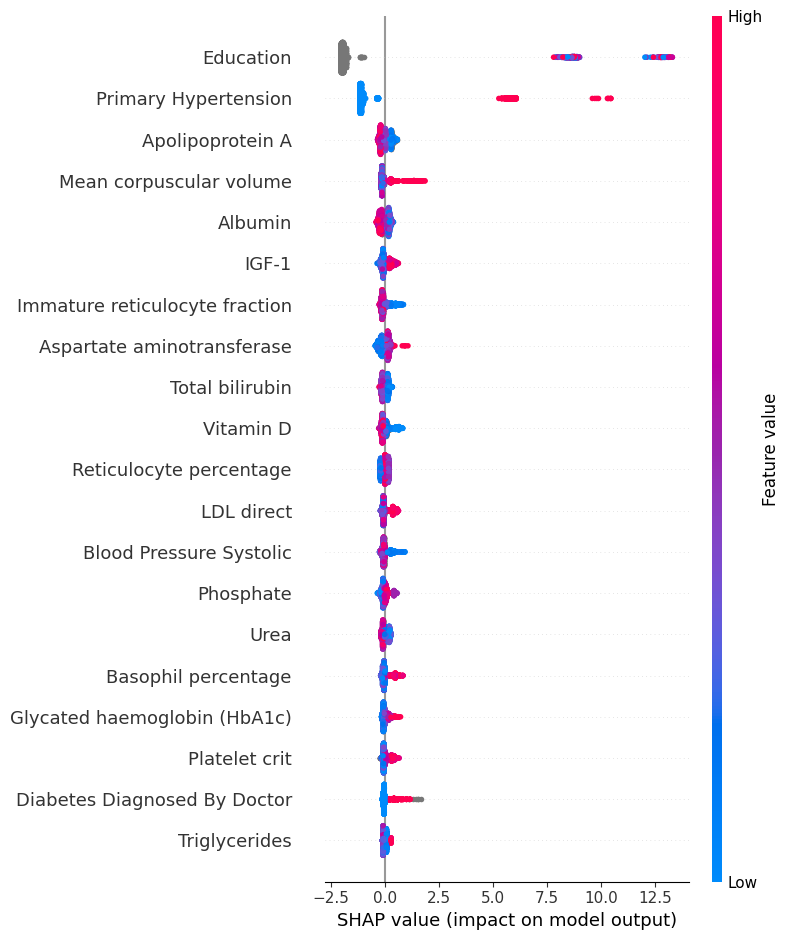

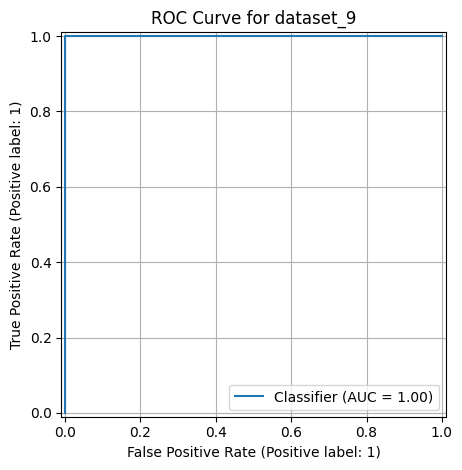

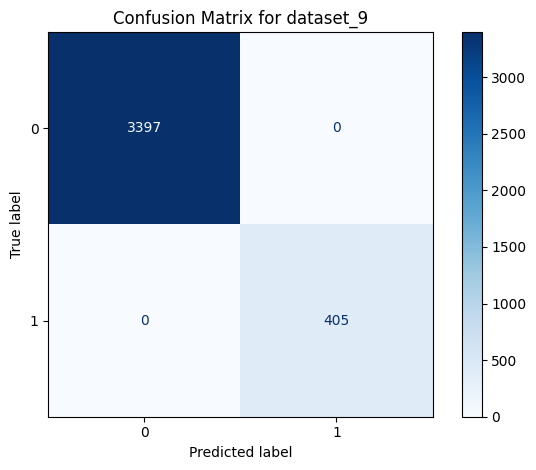

Accuracy: 1.0
ROC AUC Score: 1.0


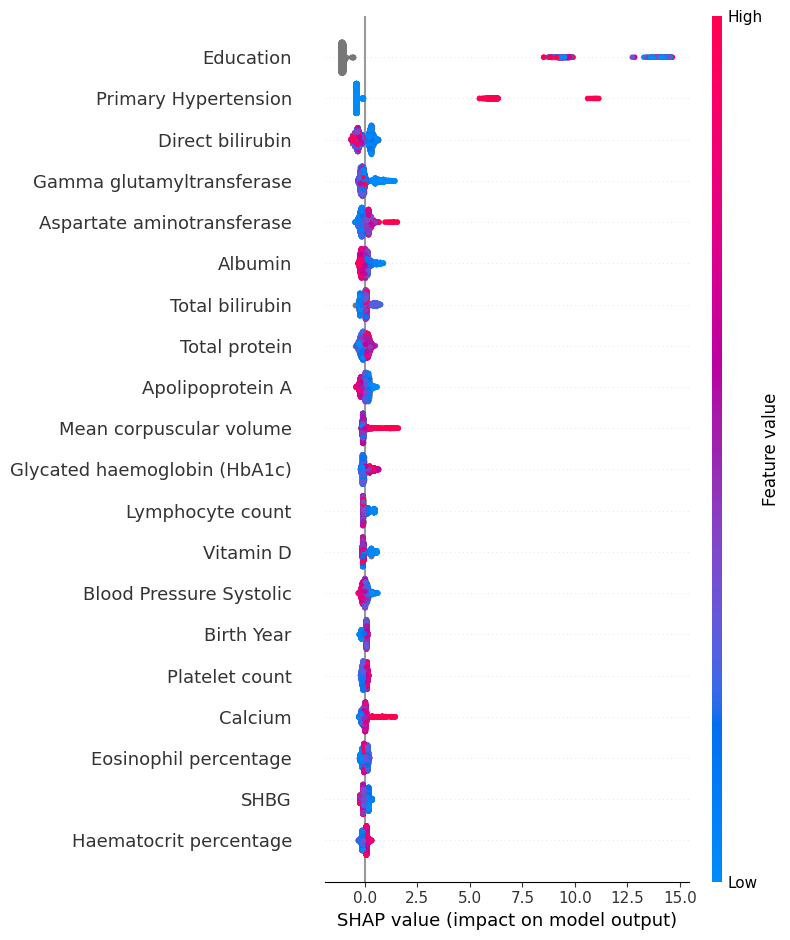

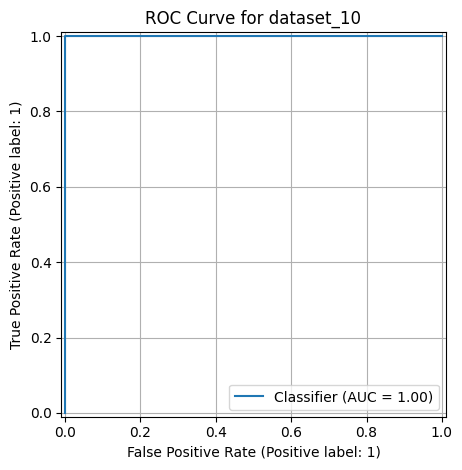

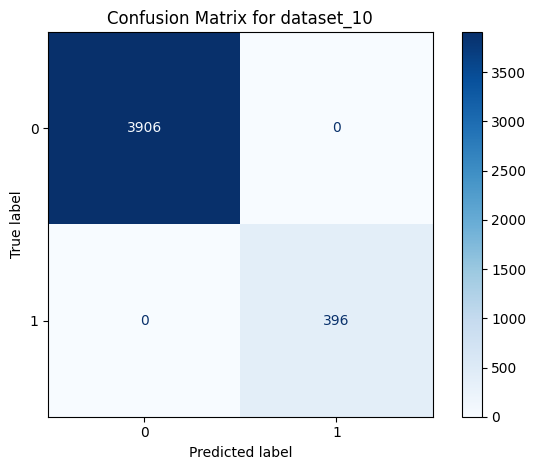

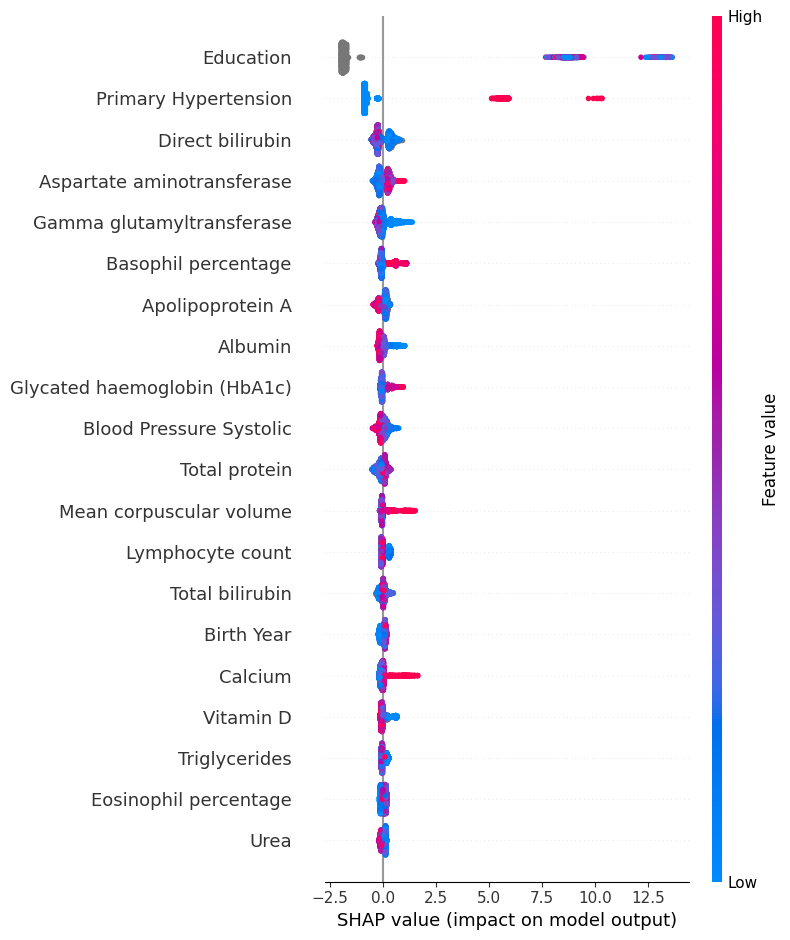

In [7]:
iterations = 10

for idx in range(1, iterations + 1):
    
    X_train, X_test, y_train, y_test = create_dataset([], idx)
    
    xgb_model, y_pred, y_prob = train_dataset(X_train, X_test, y_train, y_test)
    
    plot_ROC(y_test, y_prob, idx)
    
    plot_confusion(y_test, y_pred, idx)
    
    plot_explainer(xgb_model, X_train, X_test, idx)
    